In [35]:
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import numpy as np
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm import tqdm

In [36]:
device = torch.device("mps")

In [37]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [38]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
    
    # Use a sigmoid here to ensure that the values are between 0 and 1 for "brightness"
    def forward(self, x):
        x = F.relu(self.linear1(x))
        z = torch.sigmoid(self.linear2(x))
        return z.reshape((-1, 1, 28, 28))

In [39]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [40]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.AdamW(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x_hat - x) ** 2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [41]:
latent_dims = 2
autoencoder = AutoEncoder(latent_dims).to(device)

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)

100%|██████████| 20/20 [01:27<00:00,  4.37s/it]


In [42]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

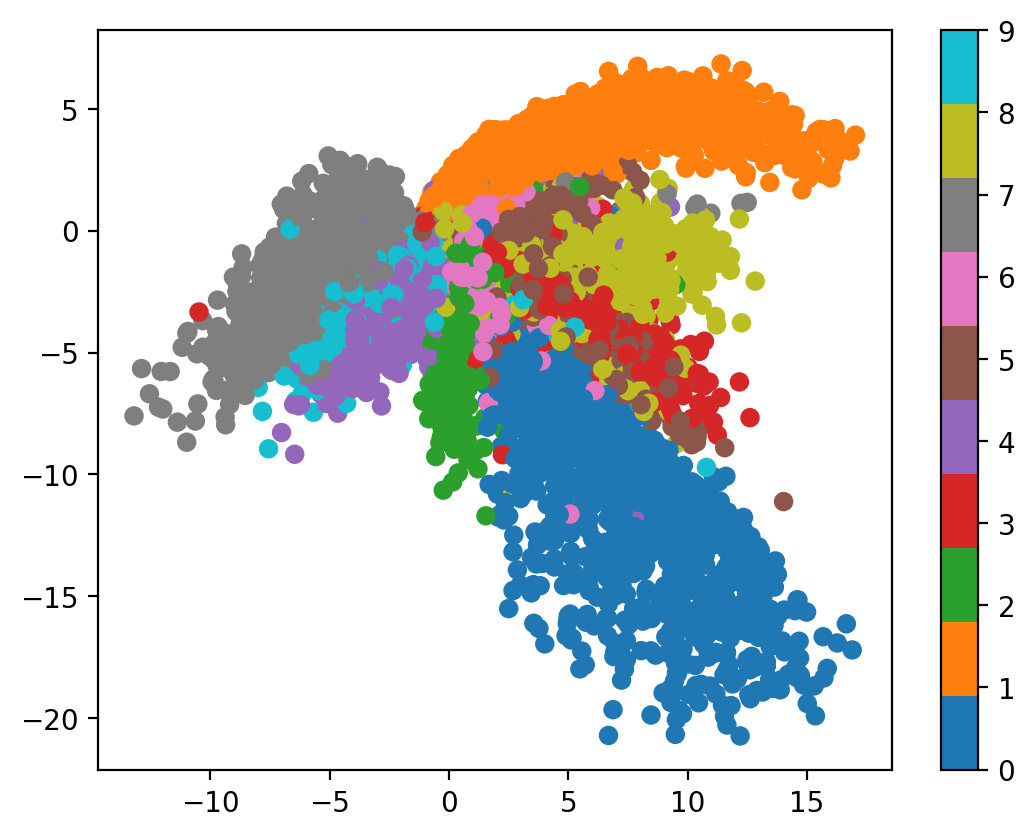

In [43]:
plot_latent(autoencoder, data)


In [44]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

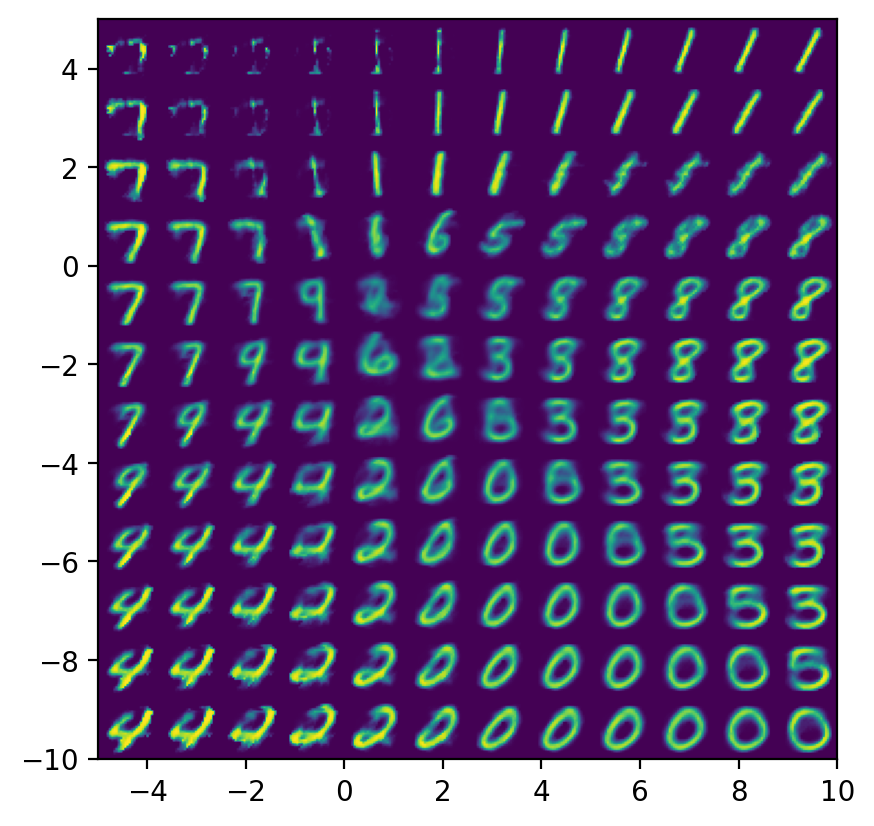

In [45]:
plot_reconstructed(autoencoder)

Like the initial blog post suggests, this kind of architecture only wants to ensure that some sort of latent that it sees has a reasonable decoding. The issue with this is that you can't use it for generative models since it won't completely fill a space or try to interpolate.

A VAE fixes this by instead of having a deterministic latent space, it produces a mean and std vector which we sample from, but the problem with this is that sampling is **not** differentiable!

In [64]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [65]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [74]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [75]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:49<00:00,  5.46s/it]


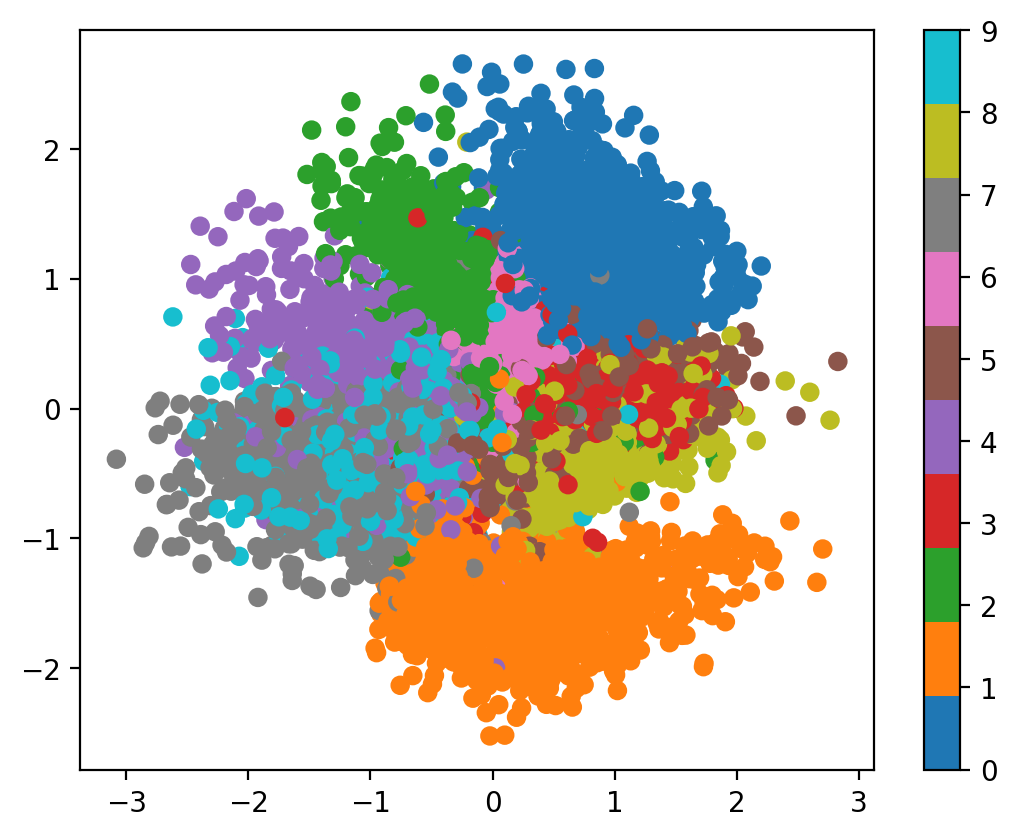

In [76]:
plot_latent(vae, data)

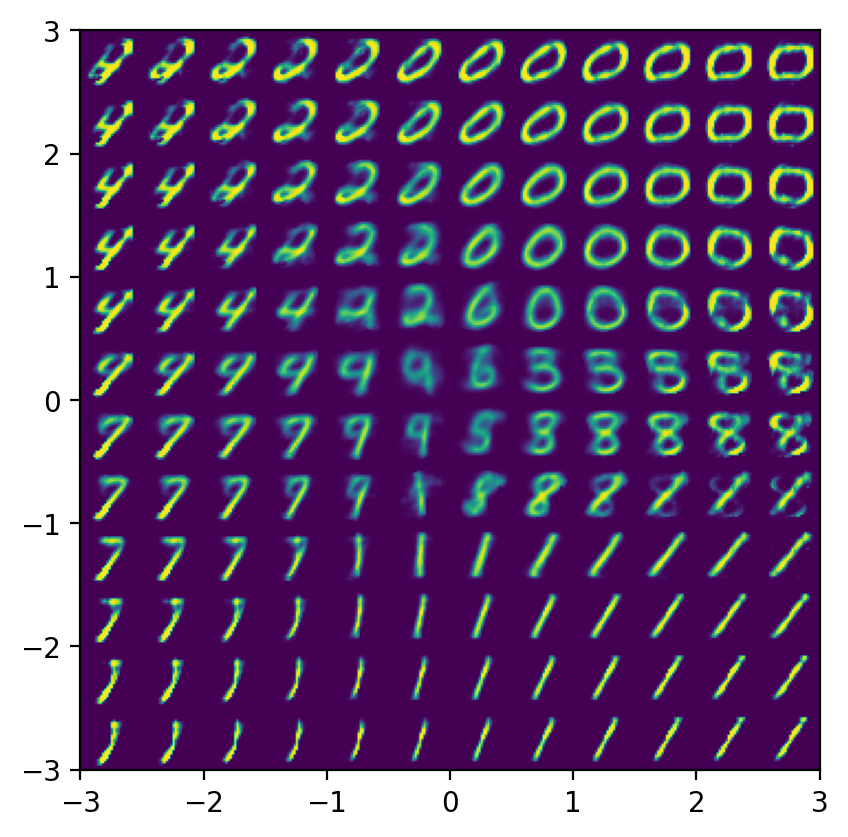

In [77]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))